In [1]:
## 기본 패키지 모음
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
 
## 전처리 및 모델링 준비를 위한 패키지
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
 
## 실제 모델링을 위한 패키지
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
 
## 모델 평가를 위한 패키지
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
 
wine = pd.read_csv('D:/data/winequality_red.csv')
wine = pd.DataFrame(wine)

In [2]:
## 5.5점을 기준으로 좋은 와인과 나쁜 와인을 구분
bins = (2, 5.5, 8)
group_names = ['bad', 'good']
wine['quality'] = pd.cut(wine['quality'], bins = bins,  labels = group_names)

#quality의 good, bad를 인식할 수 없어서 인코딩 실시
label_quality = LabelEncoder()
wine['quality'] = label_quality.fit_transform(wine['quality'])

In [3]:
print(wine['quality'].value_counts())

1    855
0    744
Name: quality, dtype: int64


In [4]:
X = wine.drop('quality', axis = 1)
y = wine['quality']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

In [5]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

### Logistic Regression ###

In [6]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [7]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.71      0.71       376
           1       0.75      0.75      0.75       424

    accuracy                           0.73       800
   macro avg       0.73      0.73      0.73       800
weighted avg       0.73      0.73      0.73       800



In [8]:
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.73375


### KNeighbors Classifier ###

In [9]:
for n_neighbour in [2,3,4,5,6]:
    knn = KNeighborsClassifier(n_neighbour)
    knn.fit(X_train, y_train)
    knn_pred = knn.predict(X_test)
    print("KNeighbor", n_neighbour)
    print("Accuracy:", metrics.accuracy_score(y_test, knn_pred))
    print(classification_report(y_test, knn_pred))

KNeighbor 2
Accuracy: 0.6825
              precision    recall  f1-score   support

           0       0.63      0.79      0.70       376
           1       0.76      0.59      0.66       424

    accuracy                           0.68       800
   macro avg       0.69      0.69      0.68       800
weighted avg       0.70      0.68      0.68       800

KNeighbor 3
Accuracy: 0.6875
              precision    recall  f1-score   support

           0       0.69      0.62      0.65       376
           1       0.69      0.75      0.72       424

    accuracy                           0.69       800
   macro avg       0.69      0.68      0.68       800
weighted avg       0.69      0.69      0.69       800

KNeighbor 4
Accuracy: 0.70375
              precision    recall  f1-score   support

           0       0.67      0.72      0.70       376
           1       0.74      0.69      0.71       424

    accuracy                           0.70       800
   macro avg       0.70      0.70      0

### Random Forest ###

In [21]:
random = RandomForestClassifier(n_estimators=500)
random.fit(X_train, y_train)

pred_random = random.predict(X_test)

print(classification_report(y_test, pred_random))

print("Accuracy:", metrics.accuracy_score(y_test, pred_random))

              precision    recall  f1-score   support

           0       0.74      0.73      0.74       376
           1       0.76      0.78      0.77       424

    accuracy                           0.76       800
   macro avg       0.75      0.75      0.75       800
weighted avg       0.75      0.76      0.75       800

Accuracy: 0.755


1. feature alcohol (0.187)
2. feature sulphates (0.144)
3. feature volatile acidity (0.117)
4. feature total sulfur dioxide (0.092)
5. feature density (0.080)
6. feature chlorides (0.072)
7. feature citric acid (0.068)
8. feature fixed acidity (0.064)
9. feature pH (0.063)
10. feature free sulfur dioxide (0.061)
11. feature residual sugar (0.052)


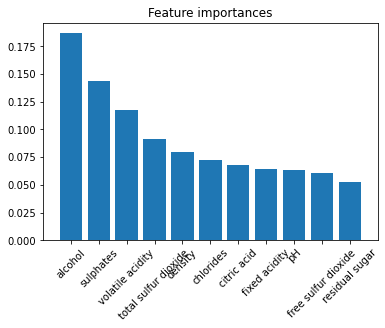

In [11]:
importances = random.feature_importances_
std = np.std([tree.feature_importances_ for tree in random.estimators_], axis = 0)
indices = np.argsort(importances)[::-1]

for f in range(X.shape[1]):
    print("{}. feature {} ({:.3f})".format(f+1, X.columns[indices][f], importances[indices][f]))
    
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=45)
plt.xlim([-1, X.shape[1]])
plt.show()

### Roc curve ###

In [12]:
from scipy import interp
from sklearn.metrics import roc_curve, auc
import numpy

def avg_roc(cv, estimator, data, target, pos_label):
    mean_fpr = np.linspace(0, 1, 100) # = [0.0, 0.01, 0.02, 0.03, ... , 0.99, 1.0]
    tprs = []
    aucs = []
    
    for train_indices, test_indices in cv.split(data, target):
        train_data = data.iloc[train_indices]
        train_target = target[train_indices]
        estimator.fit(train_data, train_target)

        test_data = data.iloc[test_indices]
        test_target = target[test_indices]
        decision_for_each_class = estimator.predict_proba(test_data)#have to use predict_proba or decision_function 
    
        fpr, tpr, thresholds = roc_curve(test_target, decision_for_each_class[:,1], pos_label=pos_label)
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0 # tprs[-1] access the last element
        aucs.append(auc(fpr, tpr))
        
        #plt.plot(fpr, tpr)# plot for each fold
        
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0 # set the last tpr to 1
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    return mean_fpr, mean_tpr, mean_auc, std_auc

<ipython-input-12-dbc346a92b3a>:20: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
<ipython-input-12-dbc346a92b3a>:20: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
<ipython-input-12-dbc346a92b3a>:20: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
<ipython-input-12-dbc346a92b3a>:20: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
<ipython-input-12-dbc346a92b3a>:20: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
<ipython-input-12-dbc346a92b3a>:20: DeprecationWarning: scipy.interp i

<ipython-input-12-dbc346a92b3a>:20: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
C:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
<ipython-input-12-dbc346a92b3a>:20: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr, fpr, tpr))
C:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
S

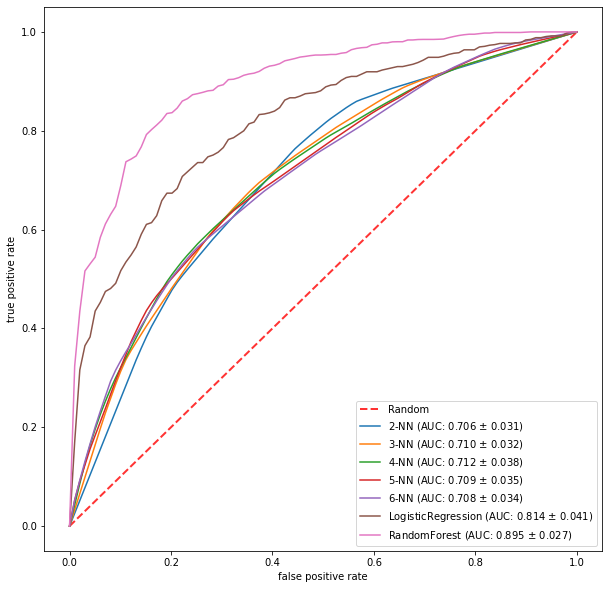

In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

preprocessor = ColumnTransformer(
    transformers=[('scaler', StandardScaler(), ['fixed acidity','volatile acidity','citric acid','residual sugar','chlorides',
                                                'free sulfur dioxide','total sulfur dioxide','density','pH','sulphates','alcohol']) ])

pipeline = Pipeline([ ('preprocessing', preprocessor), ('estimator', None) ])

plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random', alpha=.8) # draw diagonal

# KNN
for n_neighbour in [2,3,4,5,6]:
    mean_fpr, mean_tpr, mean_auc, std_auc = avg_roc(cv, KNeighborsClassifier(n_neighbour), X, y, 1)
    plt.plot(mean_fpr, mean_tpr, label='{}-NN (AUC: {:.3f} $\pm$ {:.3f})'.format(n_neighbour, mean_auc, std_auc))
    
#LogisticRegression
mean_fpr, mean_tpr, mean_auc, std_auc = avg_roc(cv, LogisticRegression(), X, y, 1)
plt.plot(mean_fpr, mean_tpr, label='LogisticRegression (AUC: {:.3f} $\pm$ {:.3f})'.format(mean_auc, std_auc))

#RandomForest
mean_fpr, mean_tpr, mean_auc, std_auc = avg_roc(cv, random, X, y, 1)
plt.plot(mean_fpr, mean_tpr, label='RandomForest (AUC: {:.3f} $\pm$ {:.3f})'.format(mean_auc, std_auc))

plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend()
plt.show()

### Confusion Matrix ###

In [14]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

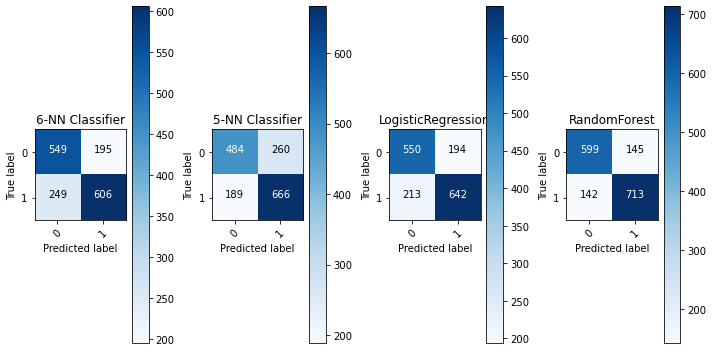

In [15]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

plt.figure(figsize=(10,5))

classes = y.unique()

# KNN
plt.subplot(1,4,1)
pipeline.set_params(estimator=KNeighborsClassifier(6))
prediction = cross_val_predict(pipeline, X, y, cv=cv)
cnf_matrix = confusion_matrix(y, prediction, labels=classes)
plot_confusion_matrix(cnf_matrix, classes=classes, title='6-NN Classifier')

plt.subplot(1,4,2)
pipeline.set_params(estimator=KNeighborsClassifier(5))
prediction = cross_val_predict(pipeline, X, y, cv=cv)
cnf_matrix = confusion_matrix(y, prediction, labels=classes)
plot_confusion_matrix(cnf_matrix, classes=classes, title='5-NN Classifier')

#LogisticRegression
plt.subplot(1,4,3)
pipeline.set_params(estimator=LogisticRegression())
prediction = cross_val_predict(pipeline, X, y, cv=cv)
cnf_matrix = confusion_matrix(y, prediction, labels=classes)
plot_confusion_matrix(cnf_matrix, classes=classes, title='LogisticRegression')

# RandomForest
plt.subplot(1,4,4)
pipeline.set_params(estimator=random)
prediction = cross_val_predict(pipeline, X, y, cv=cv)
cnf_matrix = confusion_matrix(y, prediction, labels=classes)
plot_confusion_matrix(cnf_matrix, classes=classes, title='RandomForest')